In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [8]:
from pathlib import Path

from cycler import cycler

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from matplotlib import rcParams

import numpy as np
import pandas as pd
import cmocean
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import intro_plots as ip

paper_path = Path('../paper/figures/')

slide_path = Path('../slides/figures/intro/')
proposal_path = Path('../draft/figures/intro/')
#rcParams['font.family'] = 'Segoe Print'

In [9]:
ny_all = pd.read_csv("nydata")

ny = ny_all[ny_all['NAME'].isin(ip.cdict.keys())].copy().fillna(0)

ny['DATES'] = pd.to_datetime(ny['DATE'])

nymap = ny.groupby('NAME').agg({'TAVG':'mean', 'PRCPI':np.nansum, 'LATITUDE':'mean', 'LONGITUDE':'mean'})

nygdf = gpd.GeoDataFrame(nymap[['TAVG', 'PRCPI']],  geometry=gpd.points_from_xy(nymap['LONGITUDE'], nymap['LATITUDE']))

ny['TEMP (°F)'] = ny['TAVG'].apply(lambda x: f"{x:2.2f}")
ny['PRCP (in.)'] = ny['PRCPI'].apply(lambda x: f"{x:1.4f}")                                                                                           
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', 
                                         category='cultural', name=shapename)
nystate = gpd.read_file(states_shp)

In [10]:
dfs = ny[['DATE', 'LATITUDE', 'LONGITUDE', 'PRCP (in.)', 'NAME']][ny['DATE']=='2021-01-01']
dfp = dfs.set_index('NAME').loc[ip.ssubset].reset_index()
dfp = dfp[['DATE', 'LATITUDE', 'LONGITUDE','PRCP (in.)', 'NAME']]
dfp

,DATE,LATITUDE,LONGITUDE,PRCP (in.),NAME
0,2021-01-01,43.1167,-77.6767,0.2205,ROCHESTER GTR INTL AP
1,2021-01-01,41.5000,-73.9000,0.0000,STONYKILL NEW YORK
2,2021-01-01,42.7431,-73.8092,0.2598,ALBANY AP
3,2021-01-01,43.8000,-73.7000,0.0000,SCHROON LAKE NEW YORK
4,2021-01-01,43.0078,-73.6511,0.0000,SARA NEW YORK
5,2021-01-01,40.7794,-73.8803,0.6614,NEW YORK LAGUARDIA AP
6,2021-01-01,40.6386,-73.7622,0.6299,NEW YORK JFK INTL AP
7,2021-01-01,43.1111,-76.1039,0.4094,SYRACUSE HANCOCK INTL AP
8,2021-01-01,40.7939,-73.1017,0.5984,ISLIP LI MACARTHUR AP
9,2021-01-01,43.3500,-73.6167,0.1181,GLENS FALLS AP


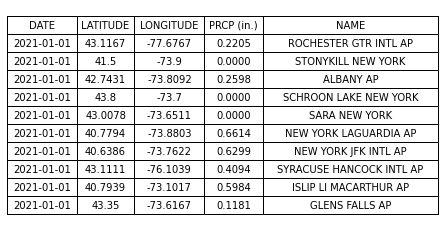

In [11]:
fig, ax = plt.subplots()
tab = ip.plot_table(ax, dfp, ['black', 'black', 'black', 'black', 'black'])
fig.savefig(slide_path/"table.png", bbox_inches='tight')

In [12]:
def get_row(table, row):
    return {'date': pd.to_datetime(tab[row,0].get_text().get_text()),
            'lat': float(tab[row,1].get_text().get_text()),
            'lon': float(tab[row,2].get_text().get_text()), 
            'prcp':float(tab[row,3].get_text().get_text()), 
            'station': tab[row,4].get_text().get_text()}

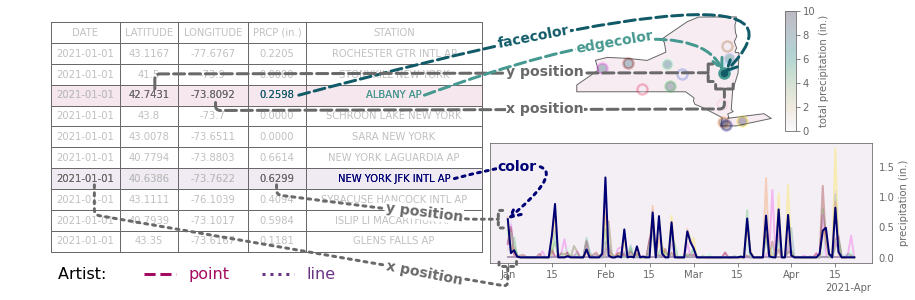

In [33]:
macolor= '#A50B5E'
tacolor= '#6c3483'
fade='dimgray'
alpha = .3
cmap = cmocean.cm.rain
norm = mcolors.Normalize(vmin=0, vmax=10)

    
fig, axd = plt.subplot_mosaic([['table', 'map'],
                               ['table', 'time',]], 
                              constrained_layout=True, figsize=(12,4))
tab = ip.plot_table(axd['table'], dfp, ['black', 'black', 'black', 'black', 'black'],  
                                 edgecolor=fade, textcolor='silver')
tab[(0,4)].get_text().set_text('STATION')

mr = 3
mdata = get_row(tab, mr)
tr = 7
tdata = get_row(tab, tr)

station_map = mdata['station']
station_time = tdata['station']

ip.plot_map(axd['map'], nygdf, nystate, cmap, norm, fade, alpha, station_map)

ip.plot_time(axd['time'], ny, fade, alpha, station_time)

#arrows
arrow_kws = {'linewidth':3, 'mutation_scale':25} 
font_kw = {'fontsize':14, 'fontweight':'bold', 'va':'center', 'ha':'left', 'zorder':15}
bbox = {'facecolor':'white', 'edgecolor':'white','pad':.02}
pos_color = 'dimgray'

#map
mls = 'dashed'
arrow_kws['linestyle'] = mls 


#x position
xpx, xpy = ip.source_cell(tab[(mr,2)], pos_color, .5, .15)
xpos_map = mpatches.ConnectionPatch(xyA=(xpx, xpy), coordsA=axd['table'].transData,
                                     xyB=(mdata['lon'], mdata['lat']-.65), coordsB=axd['map'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=0", 
                        connectionstyle="arc,angleA=-90, angleB=-90,armA=8, armB=20,rad=5", 
                                    color=pos_color, zorder=10, **arrow_kws)
fig.add_artist(xpos_map)
fig.text(.53, .65, "x position", bbox=bbox, rotation=0, color=pos_color, **font_kw)

#y position
ypx, ypy = ip.source_cell(tab[(mr,1)], pos_color, yr=.8)
ypos_map = mpatches.ConnectionPatch(xyA=(ypx, ypy), coordsA=axd['table'].transData,
                                     xyB=(mdata['lon']-.65, mdata['lat']), coordsB=axd['map'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=0", 
                                    connectionstyle='arc,angleA=90, angleB=180,armA=15, armB=30,rad=5', 
                                    color=pos_color,zorder=10, **arrow_kws)#"angle,angleA=90,angleB=180"
fig.add_artist(ypos_map)
fig.text(.53,.78, "y position", color=pos_color, bbox=bbox, **font_kw)


#edgecolor
ex, ey = ip.source_cell(tab[(mr,4)], ip.cdict[station_map], xr=.72)
edge_map = mpatches.ConnectionPatch(xyA=(ex, ey), coordsA=axd['table'].transData,
                                    xyB=(mdata['lon']-.05, mdata['lat']+.05), coordsB=axd['map'].transData,   
                                    arrowstyle="->", connectionstyle="angle3, angleA=20, angleB=115", 
                                    color=ip.cdict[station_map],**arrow_kws, zorder=font_kw['zorder']+1)
fig.add_artist(edge_map)
font_kww=font_kw.copy()
font_kww['zorder']=font_kw['zorder']+2
fig.text(.61,.88, "edgecolor", color=ip.cdict[station_map], rotation=10, bbox=bbox, **font_kww,)

#facecolor
face_color = cmap(norm(nygdf['PRCPI'][station_map]))
fx, fy = ip.source_cell(tab[(mr,3)], face_color, xr=.9)
face_map = mpatches.ConnectionPatch(xyA=(fx, fy), coordsA=axd['table'].transData,
                                    xyB=(mdata['lon'], mdata['lat']), coordsB=axd['map'].transData,
                                    arrowstyle="->", connectionstyle="angle3, angleA=15,angleB=45", 
                                    color=face_color,**arrow_kws)
fig.add_artist(face_map)
fig.text(.52, .9, "facecolor", color=face_color, bbox=bbox, rotation=11, **font_kw)


# time
tls = 'dotted'
arrow_kws['linestyle'] = tls
#x position
xpx, xpy = ip.source_cell(tab[(tr,0)], pos_color, yr=.2)

xpos_map = mpatches.ConnectionPatch(xyA=(xpx, xpy), coordsA=axd['table'].transData,
                                xyB=(mdates.date2num(tdata['date']), tdata['prcp']*0-.15), coordsB=axd['time'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=0", 
                        connectionstyle="arc,angleA=-90, angleB=-90,armA=30, armB=20,rad=5", 
                                    color=pos_color, zorder=10, **arrow_kws)
fig.add_artist(xpos_map)
fig.text(.39,.08, "x position", color=pos_color, rotation=-11, bbox=bbox, **font_kw)


#y position
ypx, ypy = ip.source_cell(tab[(tr,3)], pos_color, yr=.2)
ypos_map = mpatches.ConnectionPatch(xyA=(ypx, ypy), coordsA=axd['table'].transData,
                                     xyB=(mdates.date2num(tdata['date'])-3, tdata['prcp']), coordsB=axd['time'].transData,   
                         arrowstyle="-[,widthB=.35, angleB=0", 
                                    connectionstyle='arc,angleA=270, angleB=180,armA=10, armB=30,rad=5', 
                                    color=pos_color,zorder=10, **arrow_kws)#"angle,angleA=90,angleB=180"
fig.add_artist(ypos_map)
fig.text(.39, .29, "y position", bbox=bbox, color=pos_color, rotation=-7, **font_kw)

# color
cx, cy = ip.source_cell(tab[(tr,4)], ip.cdict[station_time], xr=.9)
face_map = mpatches.ConnectionPatch(xyA=(cx, cy), coordsA=axd['table'].transData,
                                    xyB=(mdates.date2num(tdata['date']), tdata['prcp']), coordsB=axd['time'].transData,   
                                    arrowstyle="->", connectionstyle="angle3, angleA=15,angleB=-140", 
                                    color=ip.cdict[station_time],**arrow_kws)
fig.add_artist(face_map)
bbox2 = bbox.copy()
tafade =  '#f5f0f6' # alpha .075 level tacolor, '#f1ecf3'
bbox2['facecolor'] =  tafade
bbox2['edgecolor'] = tafade
fig.text(.52, .45, "color", color=ip.cdict[station_time], rotation=0, bbox=bbox2, **font_kw)

afont_kws = {'fontsize':24, 'fontweight':'bold', 'va':'center', 'ha':'left', 'zorder':25}


[tab[(row, col)].set_facecolor(mcolors.to_rgba(color, alpha=.05)) 
     for col in range(5) for row, color in [(mr, macolor), (tr, tacolor)]]

for c in axd['map'].get_children():
    if isinstance(c, PatchCollection):
        c.set_facecolor(mcolors.to_rgba(macolor, alpha=.075))
axd['time'].set_facecolor(mcolors.to_rgba(tacolor, alpha=.075))

title_l = mlines.Line2D({}, [], linewidth=0, color='k', label='Artist: ' )
point_a = mlines.Line2D([],[], linewidth=3, color=macolor, linestyle=mls, label='point')
line_a = mlines.Line2D([],[], linewidth=3, color=tacolor, linestyle=tls, label='line')

lg = fig.legend(handles=[title_l, point_a, line_a], ncol=3, 
                fontsize=font_kw['fontsize']+2, labelcolor='linecolor', 
                frameon=False, facecolor='none', bbox_to_anchor=(0.35,.15), bbox_transform=fig.transFigure)
fig.savefig(proposal_path/"functions.png", bbox_inches='tight', dpi=200)